In [2]:
from pymilvus import MilvusClient, DataType

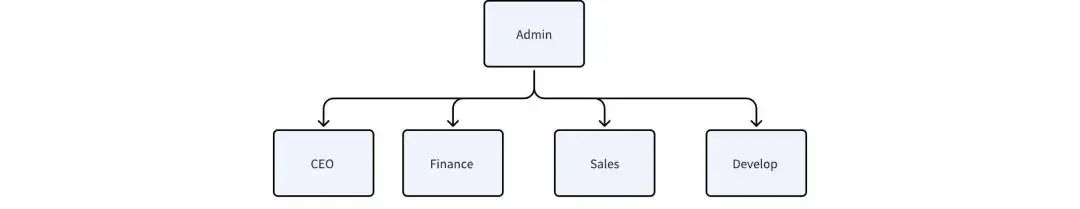

# 定义权限列

在上面所示的权限模型中，采用 array 列存储权限信息，field_name 可以自定义，array 的最大长度根据每个用户自己具体的使用场景设定，并在此列建立 BITMAP 索引，如下所示：

In [4]:
# 1. Set up a Milvus client
client = MilvusClient(
    uri="http://localhost:19530"
)

In [5]:
# 2. Create a collection
schema = MilvusClient.create_schema(
    auto_id=False,
    enable_dynamic_field=False,
)

In [7]:
# 3. define schema 
schema.add_field(field_name="id", datatype=DataType.INT64, is_primary=True)
schema.add_field(field_name="data", datatype=DataType.VARCHAR, max_length=100)
schema.add_field(field_name="vector", datatype=DataType.FLOAT_VECTOR, dim=128)

{'auto_id': False, 'description': '', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': False}, {'name': 'data', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 100}}, {'name': 'vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 128}}], 'enable_dynamic_field': False}

In [10]:
# 4. add security column
schema.add_field(field_name="security_group", datatype=DataType.ARRAY, 
                 element_type=DataType.VARCHAR, max_capacity=10, max_length=100)

index_params = MilvusClient.prepare_index_params()
index_params.add_index(
    field_name="vector",
    index_type="IVF_FLAT",
    metric_type="L2",
    params={"nlist": 1024}
)

In [11]:
# 5. create bitmap index for security column
index_params.add_index(field_name="security_group",
                       index_type="BITMAP")

In [12]:
# 6. create collection
client.create_collection(
    collection_name="test_collection",
    schema=schema,
    index_params=index_params
)

# 权限写入
在写入每行数据的时候需要指定该行数据可以被读取的role 有哪些，即在权限列写入role 角色即可， 如下所示

In [15]:
import random
data = []
data.append({
    "id": random.randint(0, 100000),
    "vector": [random.uniform(-1, 1) for _ in range(128)],
    "data": "data" + str(random.randint(0,100000)),
    # ceo role can read
    "security_group": ["ceo"]
})

data.append({
    "id": random.randint(0, 100000),
    "vector": [random.uniform(-1, 1) for _ in range(128)],
    "data": "data" + str(random.randint(0,100000)),
    # finance role can read
    "security_group": ["finance"]
})

data.append({
    "id": random.randint(0, 100000),
    "vector": [random.uniform(-1, 1) for _ in range(128)],
    "data": "data" + str(random.randint(0,100000)),
    # both sales and developer can read
    "security_group": ["sales", "finance"]
})

res = client.insert(collection_name="test_collection", data=data)

# 权限查询
当在search 或者query 查询时，需要加入对特定role 的限定查询，即只能看到指定role 的数据，其他数据对于查询role 不可见，如下所示：

## 只查询可见列

In [17]:
res = client.query(
    collection_name="test_collection",
    # 查询仅 ceo role 可见的数据
    filter='array_contains(security_group, "ceo")',
    output_fields=["id", "data", "security_group"],
)
print("ceo role read:")
print(res)

ceo role read:
data: ["{'id': 71368, 'data': 'data52159', 'security_group': ['ceo']}"] 


In [18]:
res = client.query(
    collection_name="test_collection",
    # 查询仅 sales role 可见的数据
    filter='array_contains(security_group, "sales")',
    output_fields=["id", "data", "security_group"],
)
print("sales role read:")
print(res)

sales role read:
data: ["{'id': 58510, 'data': 'data11685', 'security_group': ['sales', 'finance']}"] 


In [19]:
res = client.query(
    collection_name="test_collection",
    # 查询仅 developer 可见的数据
    filter='array_contains(security_group, "develop")',
    output_fields=["id", "data", "security_group"],
)
print("developer role read:")
print(res)

developer role read:
data: [] 


In [20]:
res = client.query(
    collection_name="test_collection",
    # 查询仅 developer 或者 ceo 可见的数据
    filter='array_contains_any(security_group, ["develop", "ceo"])',
    output_fields=["id", "data", "security_group"],
)
print("developer or ceo role read:")
print(res)

developer or ceo role read:
data: ["{'security_group': ['ceo'], 'id': 71368, 'data': 'data52159'}"] 


可精准展示具体角色所能看到的数据，而屏蔽其权限之外的内容，同时可以通过 security_group 的 array 自由叠加权限。

## 自定义 filter + role 权限可见
用户某些情形也可以加一下自定义的查询 filter, 这些 filter 会 apply 在标量列的查询条件中，即在查询时，需加上role 的可见性与 filter 做联合查询，如下所示：

In [24]:
res = client.query(
    collection_name="test_collection",
    # sales role 查询 filter "pk in [1, 3, 5]"
    filter='id in [1, 3, 5] && array_contains(security_group, "sales")',
    output_fields=["id", "data", "security_group"],
)
res

data: [] 

In [26]:
res = client.query(
    collection_name="test_collection",
    # sales role 查询 filter "pk in [1, 3, 5]"
    filter='id in [58510] && array_contains(security_group, "sales")',
    output_fields=["id", "data", "security_group"],
)
res

data: ["{'id': 58510, 'data': 'data11685', 'security_group': ['sales', 'finance']}"] 

# 权限更新
某些时候，需要对权限进行更改，如增加某行数据对于某个Role 的权限，或者删除某行数据对于Role 的可见性，可通过milvus 的upsert 接口更新。

如下所示：

In [30]:
upsert_vector = [random.uniform(-1, 1) for _ in range(128)]
upsert_data = "data" + str(random.randint(0,100000))
upsert_row_update = {
    "id": 58510,
    "vector": upsert_vector,
    "data": upsert_data,
    # update role 
    "security_group": ["finance", "sales"]
}
res = client.upsert(
    collection_name="test_collection",
    data=upsert_row_update)

In [31]:
res

{'upsert_count': 1, 'cost': 0}